# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

# Read Data as Numpy Array

In [2]:
# load train and test data
training_data = np.load("Data/training_data.npy", allow_pickle=True)
validation_data = np.load("Data/validation_data.npy", allow_pickle=True)
print("training data shape: {}".format(training_data.shape))
print("validation data shape: {}".format(validation_data.shape))

training data shape: (170, 2)
validation data shape: (158, 2)


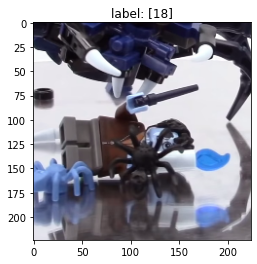

In [3]:
# plot example image
plt.imshow(training_data[10][0])
plt.title("label: {}".format(training_data[10][1]));

In [4]:
X_train = np.array([i[0] for i in training_data])
y_train = np.array([i[1][0] for i in training_data])
X_valid = np.array([i[0] for i in validation_data])
y_valid = np.array([i[1][0] for i in validation_data])

# Prepare Data for Training

In [5]:
# augment and normalize data

# create data generator
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=10)
valid_datagen = ImageDataGenerator(rescale=1./255)

# create an iterator for the datasets.
# the iterator will return one batch of augmented images for each iteration
epochs = 100
batch_size = 20
IMG_SIZE = 224
total_train = X_train.shape[0]
total_valid = X_valid.shape[0]

iter_train = train_datagen.flow(X_train, y_train, batch_size=batch_size,
                                shuffle=True)
iter_valid = train_datagen.flow(X_valid, y_valid, batch_size=batch_size)

# Define the Model

In [6]:
# use pretrained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=False,
                                               weights='imagenet')

In [7]:
# freeze model
base_model.trainable = False

In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [11]:
# Add a global spatial average pooling layer
model = Sequential([base_model,
                    BatchNormalization(),
                    Dropout(0.2),
                    GlobalAveragePooling2D(),
                    Dropout(0.2),
                    Dense(512),
                    Dropout(0.4),
                    Dense(30, activation='softmax')    
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 1280)        5120      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)              

# Train the Model

In [12]:
# compile the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# train the model
history = model.fit(
    iter_train,
    steps_per_epoch=200,#total_train // batch_size,
    epochs=epochs,
    validation_data=iter_valid,
    validation_steps=total_valid // batch_size,
    callbacks=[callback]
)

Epoch 1/100
200/200 [==============================] - 99s 494ms/step - loss: 2.6456 - accuracy: 0.8437 - val_loss: 2.8226 - val_accuracy: 0.6643
Epoch 2/100
200/200 [==============================] - 101s 503ms/step - loss: 2.4714 - accuracy: 0.9913 - val_loss: 2.7850 - val_accuracy: 0.6929
Epoch 3/100
200/200 [==============================] - 108s 538ms/step - loss: 2.4672 - accuracy: 0.9923 - val_loss: 2.7648 - val_accuracy: 0.7000
Epoch 4/100
200/200 [==============================] - 109s 546ms/step - loss: 2.4654 - accuracy: 0.9934 - val_loss: 2.7604 - val_accuracy: 0.7143
Epoch 5/100
200/200 [==============================] - 103s 517ms/step - loss: 2.4642 - accuracy: 0.9942 - val_loss: 2.7281 - val_accuracy: 0.7429
Epoch 6/100
200/200 [==============================] - 108s 538ms/step - loss: 2.4664 - accuracy: 0.9915 - val_loss: 2.8117 - val_accuracy: 0.6714
Epoch 7/100
200/200 [==============================] - 111s 556ms/step - loss: 2.4697 - accuracy: 0.9889 - val_loss: 2.

# Plot Results

In [14]:
def plot_acc_loss(acc, val_acc, loss, val_loss):

    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, color="#58D68D", linewidth=2, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, color="#F1C40F", linewidth=2, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.ylim(0,1)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, color="#58D68D", linewidth=2, label='Training Loss')
    plt.plot(epochs_range, val_loss, color="#F1C40F", linewidth=2, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

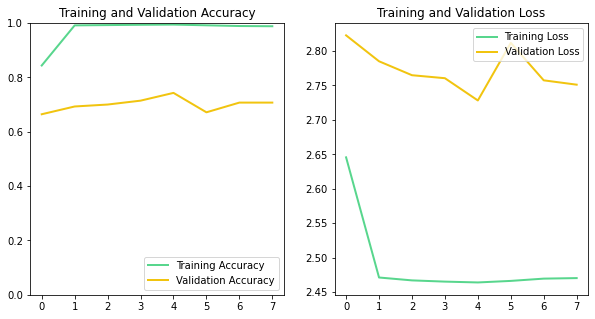

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

# Plot some example Predictions

In [16]:
sample_test_images, sample_test_labels = next(iter_valid)
predictions = model.predict(sample_test_images)

In [17]:
print("SOME PREDICTIONS:")
for i in range(5,10):
    print("-"*20)
    print("Predicted cell type of the first image: {}.".format(np.argmax(predictions[i])))
    print("True label: {}".format(int(sample_test_labels[i])))

SOME PREDICTIONS:
--------------------
Predicted cell type of the first image: 25.
True label: 21
--------------------
Predicted cell type of the first image: 12.
True label: 12
--------------------
Predicted cell type of the first image: 5.
True label: 5
--------------------
Predicted cell type of the first image: 16.
True label: 16
--------------------
Predicted cell type of the first image: 18.
True label: 23


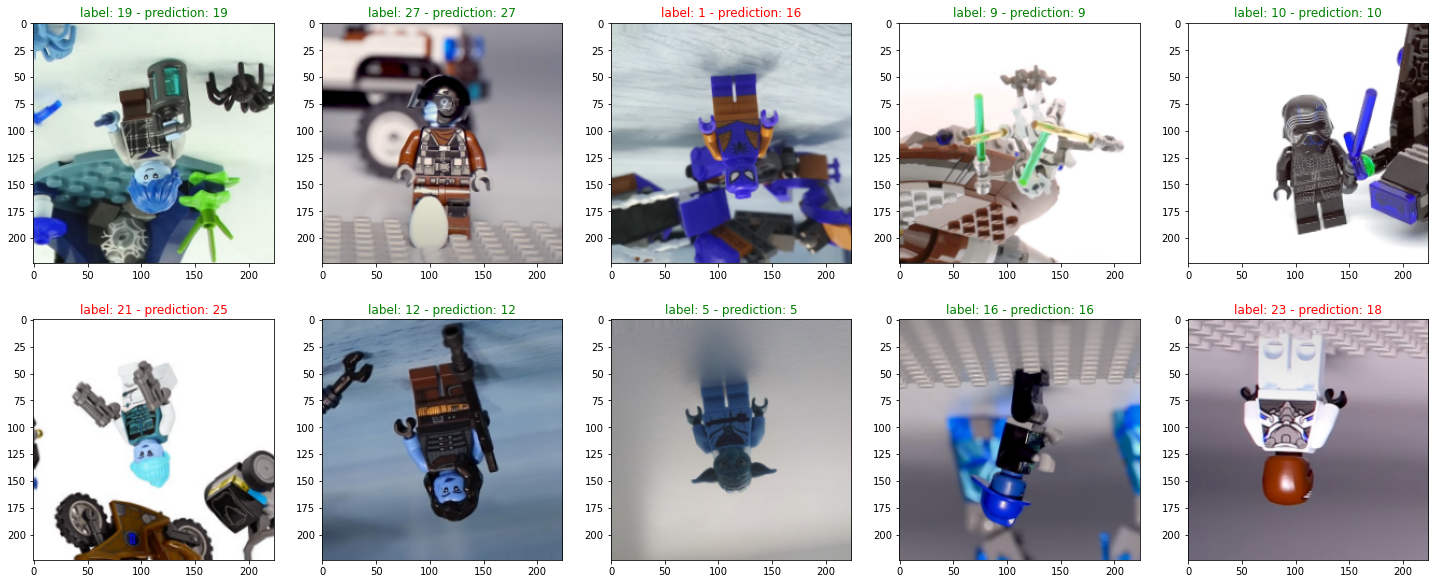

In [18]:
fig, axes = plt.subplots(2,5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):

    
    ax.imshow(sample_test_images[i])
    ax.set_title(f'label: {sample_test_labels[i].item()} - prediction: {np.argmax(predictions[i])}', 
                color=("green" if np.argmax(predictions[i])==sample_test_labels[i].item() else "red"))

# Define and compare a second Model

In [24]:
# define a second model with end from previous notebook
model1 = Sequential([base_model,
                    BatchNormalization(),
                    Flatten(),
                    Dropout(0.4),
                    Dense(512, activation='relu'), 
                    BatchNormalization(),
                    Dropout(0.4), 
                    Dense(30, activation='softmax')    
])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 1280)        5120      
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 62720)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               32113152  
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)              

In [25]:
# compile the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
# train the model
history = model1.fit(
    iter_train,
    steps_per_epoch=200,#total_train // batch_size,
    epochs=epochs,
    validation_data=iter_valid,
    validation_steps=total_valid // batch_size,
    callbacks=[callback]
)

Epoch 1/100
200/200 [==============================] - 122s 612ms/step - loss: 2.6557 - accuracy: 0.8276 - val_loss: 2.7898 - val_accuracy: 0.7246
Epoch 2/100
200/200 [==============================] - 130s 652ms/step - loss: 2.4611 - accuracy: 0.9987 - val_loss: 2.7800 - val_accuracy: 0.7899
Epoch 3/100
200/200 [==============================] - 133s 663ms/step - loss: 2.4578 - accuracy: 1.0000 - val_loss: 2.7732 - val_accuracy: 0.7754
Epoch 4/100
200/200 [==============================] - 124s 620ms/step - loss: 2.4583 - accuracy: 0.9995 - val_loss: 2.7375 - val_accuracy: 0.7899
Epoch 5/100
200/200 [==============================] - 128s 642ms/step - loss: 2.4573 - accuracy: 1.0000 - val_loss: 2.7625 - val_accuracy: 0.7899
Epoch 6/100
200/200 [==============================] - 131s 653ms/step - loss: 2.4571 - accuracy: 1.0000 - val_loss: 2.7405 - val_accuracy: 0.7899
Epoch 7/100
200/200 [==============================] - 134s 671ms/step - loss: 2.4570 - accuracy: 1.0000 - val_loss: 2

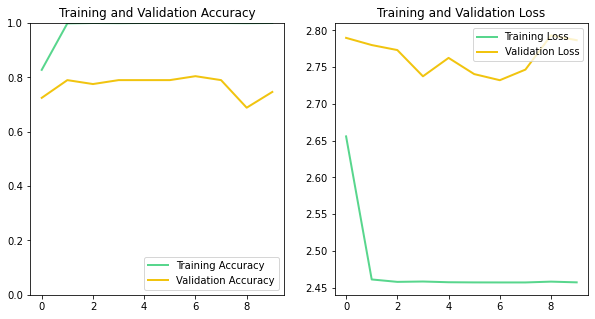

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

# Notes

* The pretrained model improves the results 
* Still overfitting